In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
import numpy as np
import scipy.stats

import sklearn.decomposition 
import sklearn.model_selection
import sklearn.pipeline
import sklearn.linear_model
import sklearn.metrics



In [4]:
from sklearn.model_selection import ShuffleSplit

In [5]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


In [6]:
rng = np.random.RandomState(0)
train_size = 0.7
K = 200

In [7]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dat['sresp'].T, dat['istim'], train_size=train_size, random_state=rng)
Z_train = scipy.stats.zscore(X_train, axis=1)
Z_test = scipy.stats.zscore(X_test, axis=1)

In [196]:
X_train.shape

(3218, 23589)

In [12]:
pipe = sklearn.pipeline.Pipeline([
                                  ('pca', sklearn.decomposition.PCA(n_components=K, whiten=True, random_state=rng)),
                                  ('linear_regression', sklearn.linear_model.LinearRegression(fit_intercept=True))
                                 ])

In [13]:
pipe.fit(Z_train, y_train)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=200,
                     random_state=RandomState(MT19937) at 0x7F0A0E09DBA0,
                     svd_solver='auto', tol=0.0, whiten=True)),
                ('linear_regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [14]:
y_train_pred = pipe.predict(Z_train)

In [15]:
y_test_pred = pipe.predict(Z_test)

In [16]:
mse = sklearn.metrics.mean_squared_error(y_test, y_test_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average test error of {round(360 * mean_error / (np.pi * 2))} degrees"""

'Our model has an average test error of 38.0 degrees'

In [18]:
sklearn.metrics.r2_score(y_test,y_test_pred)

0.8665693252391737

In [19]:
mse = sklearn.metrics.mean_squared_error(y_train, y_train_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average train error of {round(360 * mean_error / (np.pi * 2))} degrees"""

'Our model has an average train error of 37.0 degrees'

In [20]:
sklearn.metrics.r2_score(y_train,y_train_pred)

0.8757560076568155

# Linear Regression on all the linear data is not a good model because it does not generalize well to test data

In [133]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dat['sresp'].T, dat['istim'], train_size=train_size, random_state=rng)
Z_train = scipy.stats.zscore(X_train, axis=0)
Z_test = scipy.stats.zscore(X_test, axis=0)

In [134]:
reg = sklearn.linear_model.LinearRegression().fit(Z_train,y_train)

In [135]:
y_train_pred = reg.predict(Z_train)

In [136]:
y_test_pred = reg.predict(Z_test)

In [137]:
mse = sklearn.metrics.mean_squared_error(y_test, y_test_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average test error of {round(360 * mean_error / (np.pi * 2))} degrees"""

'Our model has an average test error of 40.0 degrees'

In [138]:
sklearn.metrics.r2_score(y_test,y_test_pred)

0.8510174294860486

In [139]:
mse = sklearn.metrics.mean_squared_error(y_train, y_train_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average train error of {round(360 * mean_error / (np.pi * 2))} degrees"""

'Our model has an average train error of 0.0 degrees'

In [140]:
sklearn.metrics.r2_score(y_train,y_train_pred)

1.0

# Linear regression on the data transformed to PC space does not overfit the data as much, indicating a more informative model.

In [141]:
K = 200
pipe = sklearn.pipeline.Pipeline([
                                  ('pca', sklearn.decomposition.PCA(n_components=K, whiten=True, random_state=rng)),
                                  ('linear_regression', sklearn.linear_model.LinearRegression(fit_intercept=True))
                                 ])

Using more than 200 dimensions starts to overfit the data

In [142]:
pipe.fit(Z_train, y_train)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=200,
                     random_state=RandomState(MT19937) at 0x7F0A0E09DCA8,
                     svd_solver='auto', tol=0.0, whiten=True)),
                ('linear_regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [143]:
y_train_pred = pipe.predict(Z_train)

In [144]:
y_test_pred = pipe.predict(Z_test)

In [145]:
mse = sklearn.metrics.mean_squared_error(y_test, y_test_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average test error of {round(360 * mean_error / (np.pi * 2))} degrees"""

'Our model has an average test error of 46.0 degrees'

In [146]:
mse = sklearn.metrics.mean_squared_error(y_train, y_train_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average train error of {round(360 * mean_error / (np.pi * 2))} degrees"""

'Our model has an average train error of 44.0 degrees'

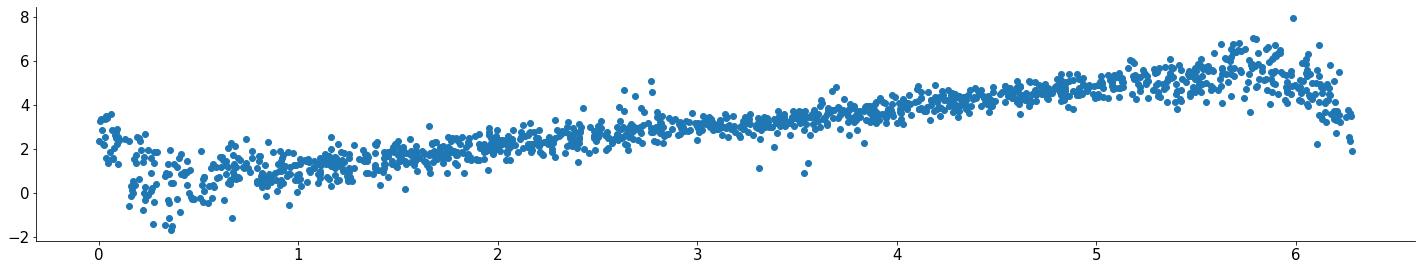

In [147]:
plt.scatter(y_test, y_test_pred)

In [148]:
sklearn.metrics.r2_score(y_test,y_test_pred)

0.8043645968353461

In [149]:
sklearn.metrics.r2_score(y_train,y_train_pred)

0.8208034282799832

## Looking at PC space of train and test data labeled by angle orientation

In [153]:
np.mean(Z_test,0)

array([-2.61948273e-16, -3.58811209e-16,  1.81416878e-16, ...,
        7.67502004e-17, -5.66696448e-16, -3.39502983e-16])

In [155]:
train_transform = pipe.named_steps['pca'].transform(Z_train)

In [157]:
test_transform = pipe.named_steps['pca'].transform(Z_test)

In [163]:
idx_ang_train = np.argsort(y_train)

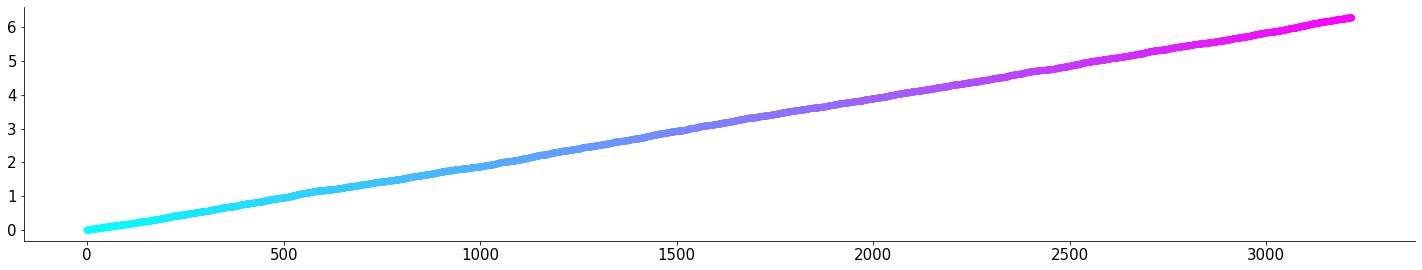

In [167]:
plt.scatter(np.arange(len(y_train)),y_train[idx_ang_train],c = np.arange(len(y_train)),cmap='cool')

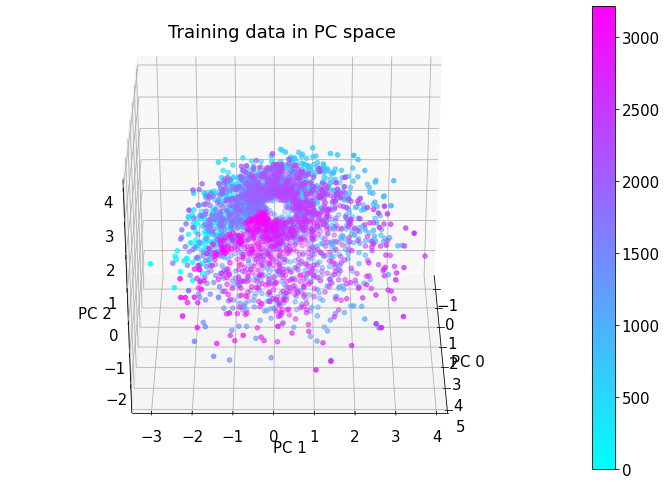

In [171]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(train_transform[idx_ang_train,0],train_transform[idx_ang_train,1],train_transform[idx_ang_train,2],c = np.arange(len(y_train)),cmap='cool')
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
plt.title('Training data in PC space')
fig.colorbar(p)
ax.view_init(30,360)

In [169]:
idx_ang_test = np.argsort(y_test)

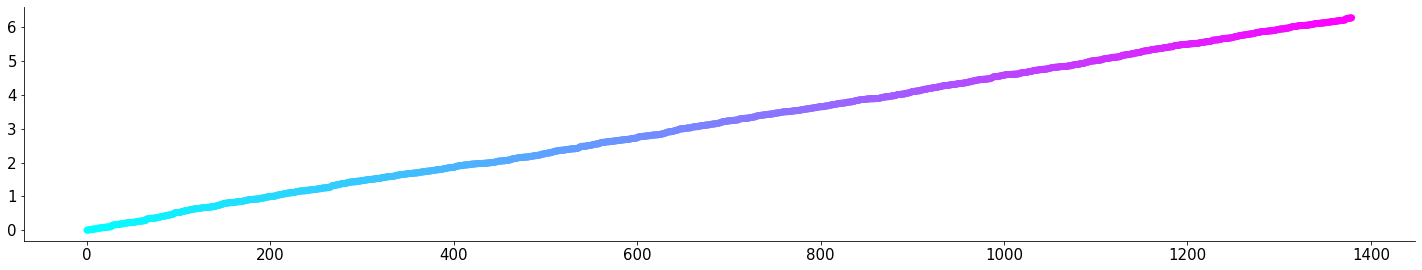

In [170]:
plt.scatter(np.arange(len(y_test)),y_test[idx_ang_test],c = np.arange(len(y_test)),cmap='cool')

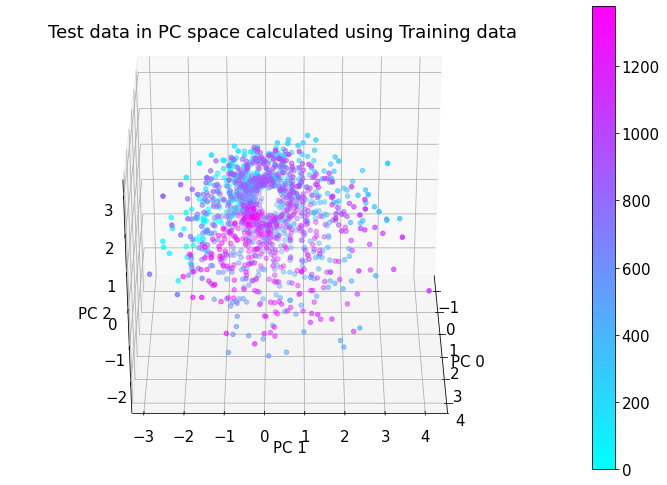

In [172]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(test_transform[idx_ang_test,0],test_transform[idx_ang_test,1],test_transform[idx_ang_test,2],c = np.arange(len(y_test)),cmap='cool')
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
plt.title('Test data in PC space calculated using Training data')
fig.colorbar(p)
ax.view_init(30,360)

# Linear regression on the data transformed onto PC space, speed

In [173]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dat['sresp'].T, dat['run'], train_size=train_size, random_state=rng)
Z_train = scipy.stats.zscore(X_train, axis=0)
Z_test = scipy.stats.zscore(X_test, axis=0)

Here, there are more speeds around zero, not evenly distributed

(array([2088.,  263.,  138.,  115.,  142.,  155.,  179.,   83.,   46.,
           9.]),
 array([ 0.       ,  7.7829804, 15.565961 , 23.348942 , 31.131922 ,
        38.9149   , 46.697884 , 54.48086  , 62.263844 , 70.04682  ,
        77.8298   ], dtype=float32),
 <a list of 10 Patch objects>)

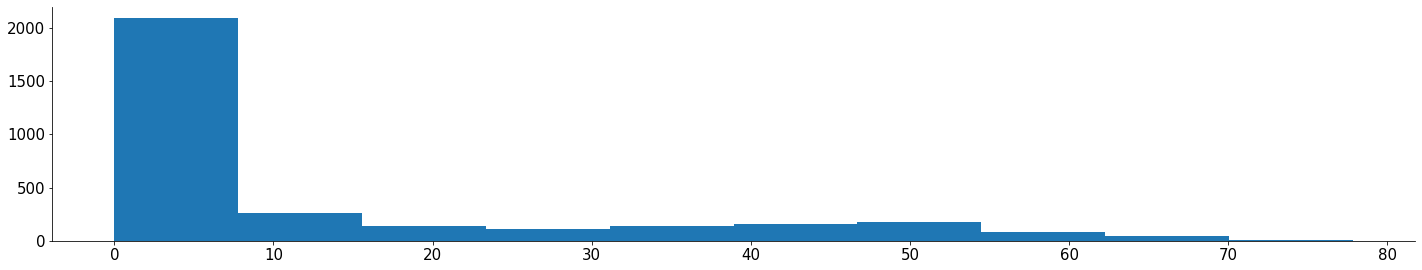

In [183]:
plt.hist(y_train)

(array([910., 115.,  64.,  48.,  53.,  76.,  67.,  35.,  11.,   1.]),
 array([ 0.      ,  8.061597, 16.123194, 24.18479 , 32.246387, 40.307983,
        48.36958 , 56.431175, 64.492775, 72.55437 , 80.61597 ],
       dtype=float32),
 <a list of 10 Patch objects>)

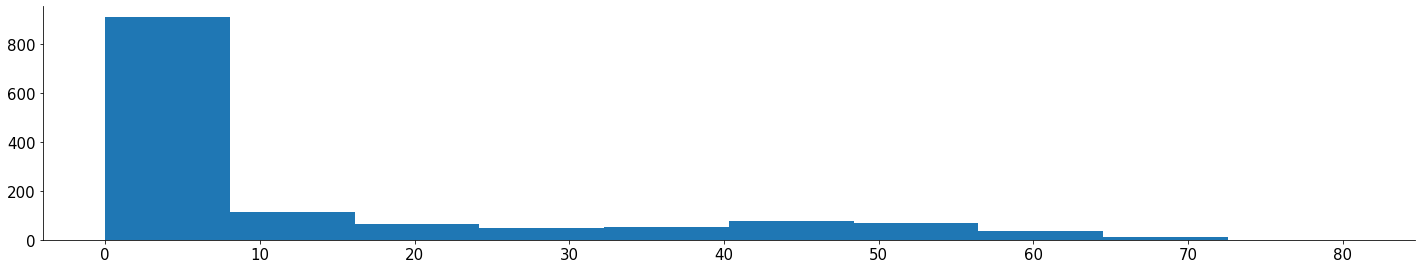

In [184]:
plt.hist(y_test)

In [174]:
K = 200
pipe = sklearn.pipeline.Pipeline([
                                  ('pca', sklearn.decomposition.PCA(n_components=K, whiten=True, random_state=rng)),
                                  ('linear_regression', sklearn.linear_model.LinearRegression(fit_intercept=True))
                                 ])

Using more than 200 dimensions starts to overfit the data

In [175]:
pipe.fit(Z_train, y_train)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=200,
                     random_state=RandomState(MT19937) at 0x7F0A0E09DCA8,
                     svd_solver='auto', tol=0.0, whiten=True)),
                ('linear_regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [176]:
y_train_pred = pipe.predict(Z_train)

In [177]:
y_test_pred = pipe.predict(Z_test)

In [178]:
mse = sklearn.metrics.mean_squared_error(y_test, y_test_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average test error of {mean_error} """

'Our model has an average test error of 7.13913749717348 '

In [179]:
mse = sklearn.metrics.mean_squared_error(y_train, y_train_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average train error of {mean_error} """

'Our model has an average train error of 6.777970806896901 '

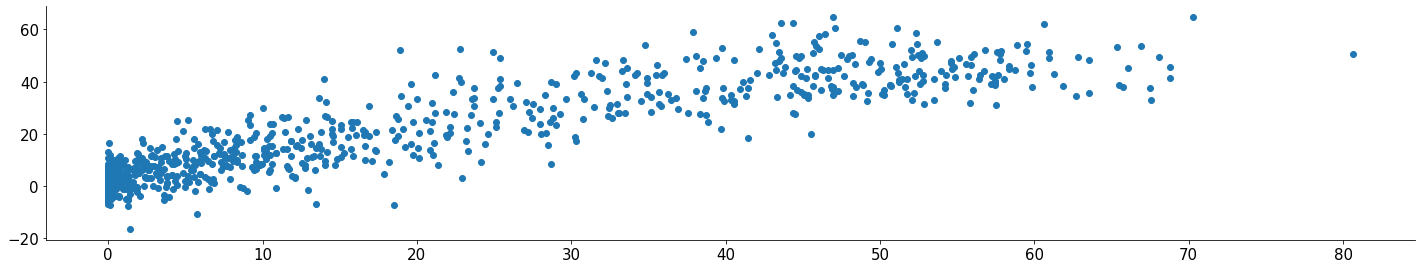

In [202]:
plt.scatter(y_test, y_test_pred)

(array([  2., 241., 597., 146.,  76.,  64., 100.,  91.,  51.,  12.]),
 array([-16.61030452,  -8.46626445,  -0.32222438,   7.8218157 ,
         15.96585577,  24.10989584,  32.25393591,  40.39797598,
         48.54201605,  56.68605612,  64.83009619]),
 <a list of 10 Patch objects>)

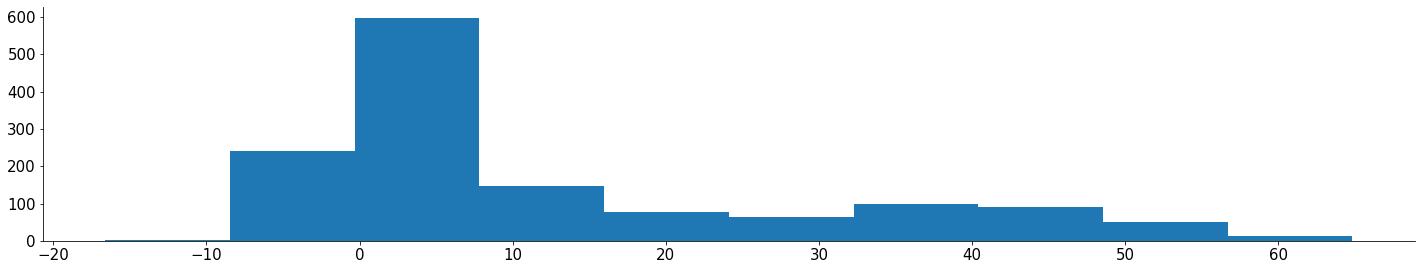

In [203]:
plt.hist(y_test_pred)

(array([910., 115.,  64.,  48.,  53.,  76.,  67.,  35.,  11.,   1.]),
 array([ 0.      ,  8.061597, 16.123194, 24.18479 , 32.246387, 40.307983,
        48.36958 , 56.431175, 64.492775, 72.55437 , 80.61597 ],
       dtype=float32),
 <a list of 10 Patch objects>)

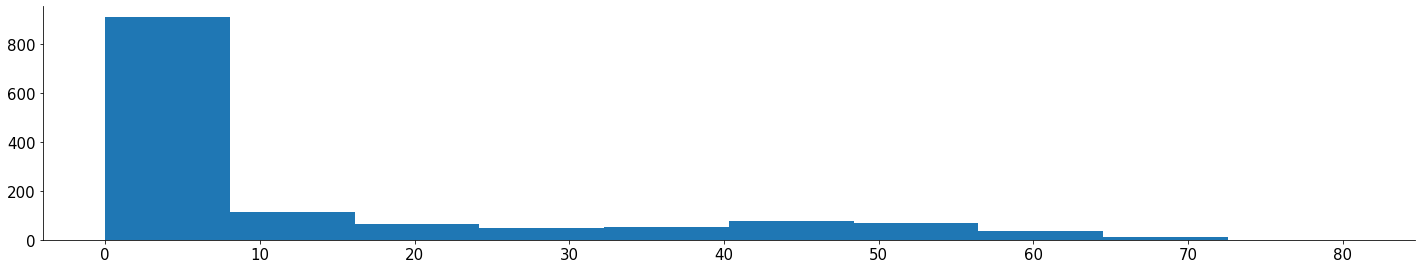

In [204]:
plt.hist(y_test)

In [185]:
sklearn.metrics.r2_score(y_test,y_test_pred)

0.8508253525179634

In [186]:
sklearn.metrics.r2_score(y_train,y_train_pred)

0.8697338071751074

## Looking at PC space of train and test data labeled by speed

In [187]:
np.mean(Z_test,0)

array([-4.00645700e-16,  2.53420473e-17,  1.03299012e-16, ...,
        8.39907853e-17,  1.46742522e-16,  6.17300092e-16])

In [188]:
train_transform = pipe.named_steps['pca'].transform(Z_train)

In [189]:
test_transform = pipe.named_steps['pca'].transform(Z_test)

In [190]:
idx_speed_train = np.argsort(y_train)

Note that the colorbar is not even

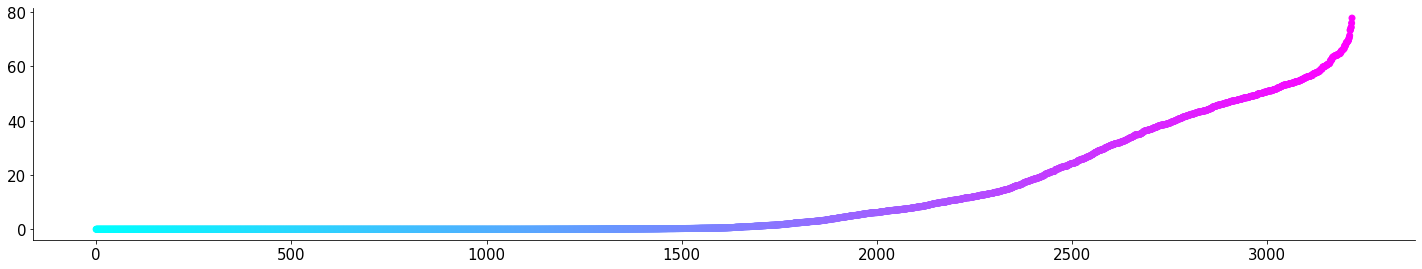

In [191]:
plt.scatter(np.arange(len(y_train)),y_train[idx_speed_train],c = np.arange(len(y_train)),cmap='cool')

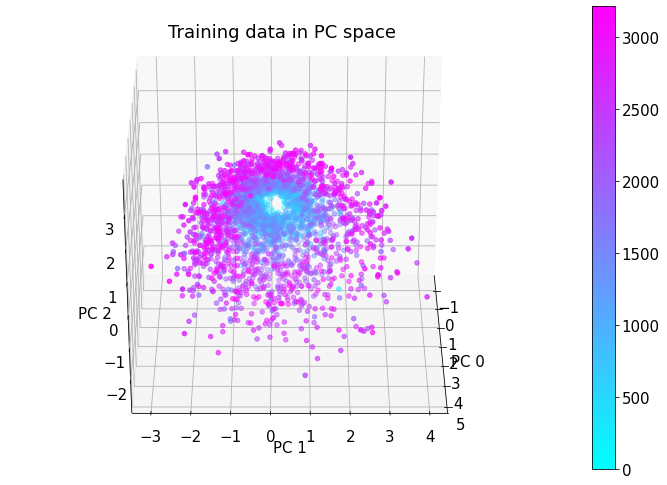

In [200]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(train_transform[idx_speed_train,0],train_transform[idx_speed_train,1],train_transform[idx_speed_train,2],c = np.arange(len(y_train)),cmap='cool')
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
plt.title('Training data in PC space')
fig.colorbar(p)
ax.view_init(30,360)

In [197]:
idx_speed_test = np.argsort(y_test)

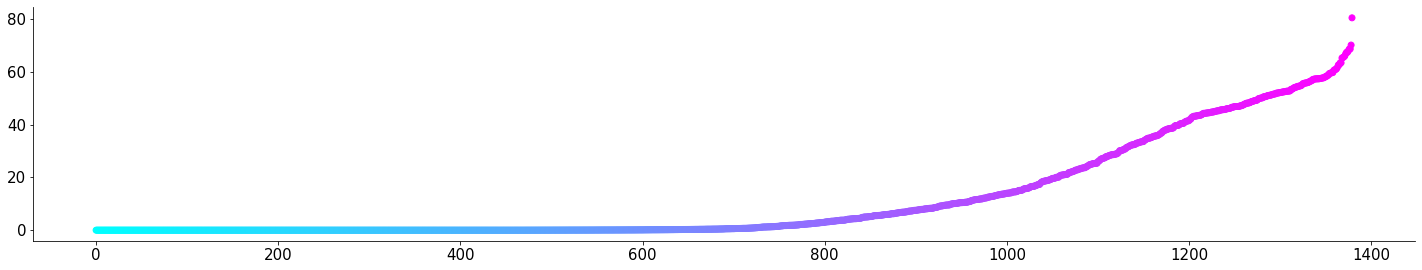

In [199]:
plt.scatter(np.arange(len(y_test)),y_test[idx_speed_test],c = np.arange(len(y_test)),cmap='cool')

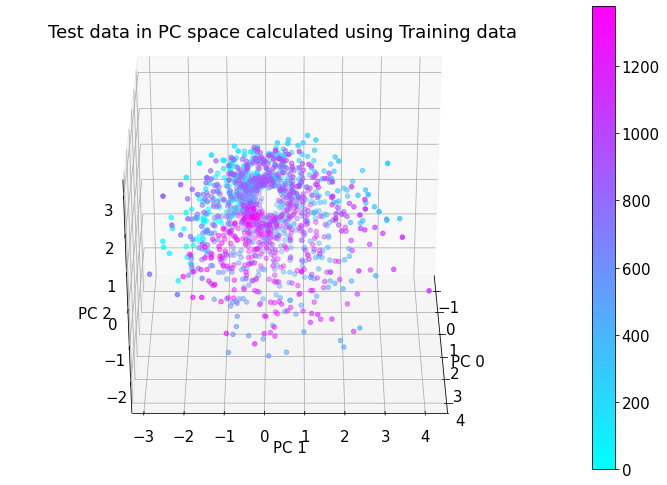

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(test_transform[idx_ang_test,0],test_transform[idx_ang_test,1],test_transform[idx_ang_test,2],c = np.arange(len(y_test)),cmap='cool')
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
plt.title('Test data in PC space calculated using Training data')
fig.colorbar(p)
ax.view_init(30,360)

# Evening the zeros from the running speed data

(array([2.617e+03, 1.960e+02, 1.980e+02, 1.470e+02, 1.340e+02, 9.400e+01,
        7.000e+01, 6.900e+01, 6.300e+01, 6.000e+01, 5.700e+01, 6.100e+01,
        6.300e+01, 6.100e+01, 7.000e+01, 6.500e+01, 8.500e+01, 9.700e+01,
        9.000e+01, 8.000e+01, 6.600e+01, 5.200e+01, 3.000e+01, 2.400e+01,
        2.200e+01, 1.600e+01, 4.000e+00, 4.000e+00, 2.000e+00, 1.000e+00]),
 array([ 0.       ,  2.6871989,  5.3743978,  8.061597 , 10.7487955,
        13.435994 , 16.123194 , 18.810392 , 21.497591 , 24.18479  ,
        26.871988 , 29.559187 , 32.246387 , 34.933586 , 37.620785 ,
        40.307983 , 42.995182 , 45.68238  , 48.36958  , 51.056778 ,
        53.743977 , 56.431175 , 59.118374 , 61.805576 , 64.492775 ,
        67.17997  , 69.86717  , 72.55437  , 75.24157  , 77.928764 ,
        80.61597  ], dtype=float32),
 <a list of 30 Patch objects>)

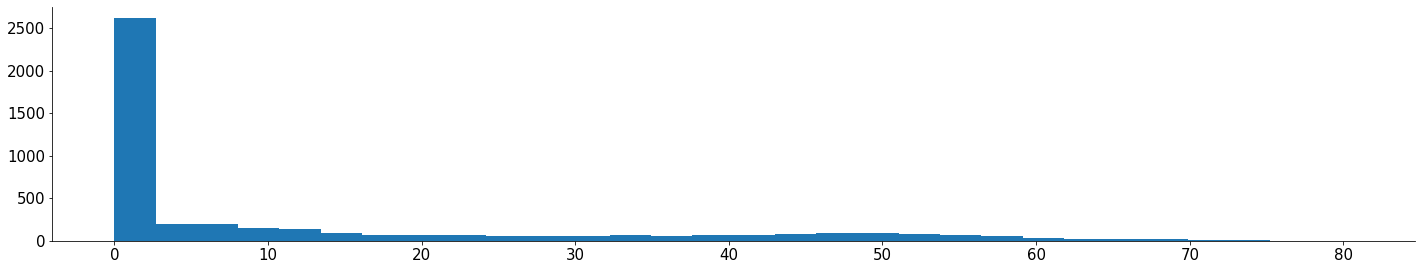

In [215]:
plt.hist(dat['run'],bins=30)

 proportion of zeros: 0.30426272292301


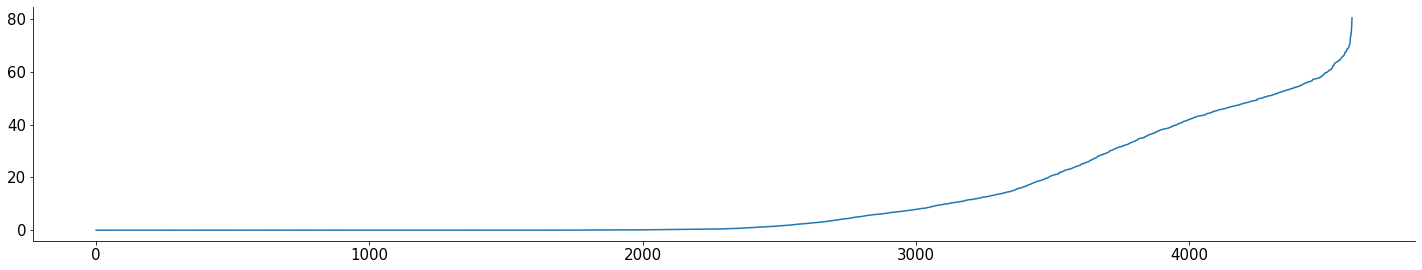

In [8]:
idx_run = np.argsort(dat['run'])
run_ordered = dat['run'][idx_run]
plt.plot(np.arange(len(dat['run'])),run_ordered)
print(f" proportion of zeros: {(len(run_ordered)-np.count_nonzero(run_ordered))/len(run_ordered)}")

 proportion of zeros: 0.11089494163424124


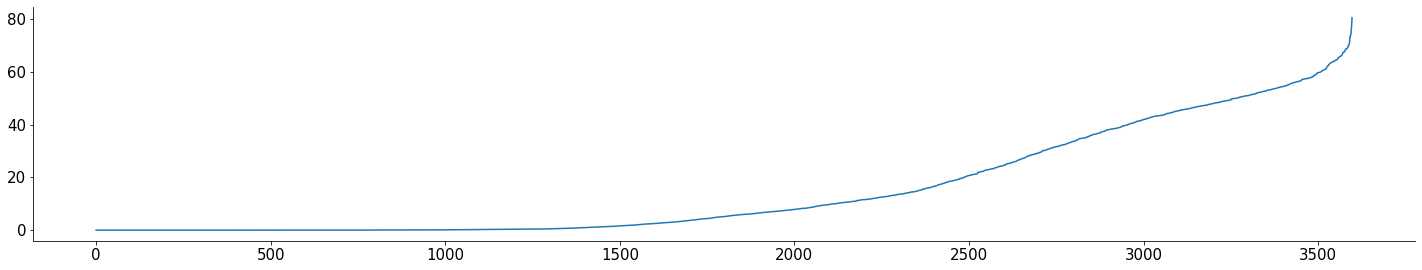

In [9]:
#remove some zeros
idx_run_r0 = idx_run[1000:]
run_ordered_r0 = dat['run'][idx_run_r0]
plt.plot(np.arange(len(run_ordered_r0)),run_ordered_r0)
print(f" proportion of zeros: {(len(run_ordered_r0)-np.count_nonzero(run_ordered_r0))/len(run_ordered_r0)}")

In [10]:
# remove zeros from the neural response data and order using the same ordering used for the ordered run with zeros removed
dat_r = dat['sresp'][:,idx_run_r0]
dat_a = dat['istim'][idx_run_r0]

(array([2011.,  375.,  202.,  178.,  194.,  247.,  236.,  106.,   42.,
           7.]),
 array([ 0.      ,  8.061597, 16.123194, 24.18479 , 32.246387, 40.307983,
        48.36958 , 56.431175, 64.492775, 72.55437 , 80.61597 ],
       dtype=float32),
 <a list of 10 Patch objects>)

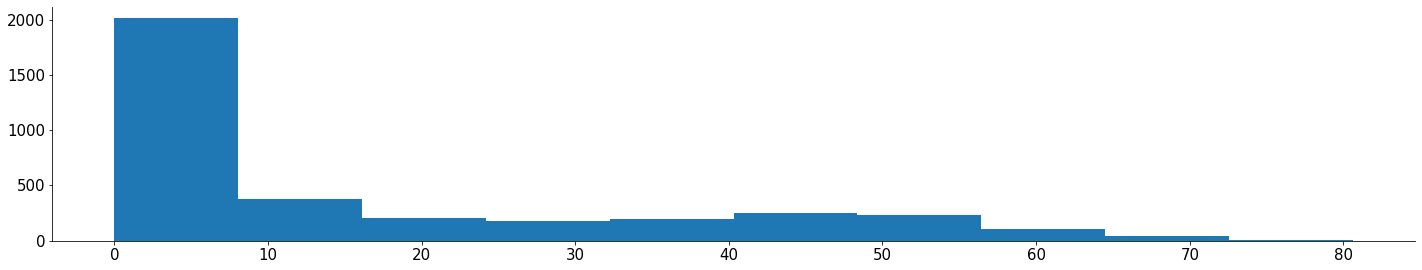

In [11]:
plt.hist(run_ordered_r0)

(array([386., 340., 384., 348., 347., 361., 349., 354., 385., 344.]),
 array([6.09159136e-04, 6.27937181e-01, 1.25526520e+00, 1.88259323e+00,
        2.50992125e+00, 3.13724927e+00, 3.76457729e+00, 4.39190531e+00,
        5.01923334e+00, 5.64656136e+00, 6.27388938e+00]),
 <a list of 10 Patch objects>)

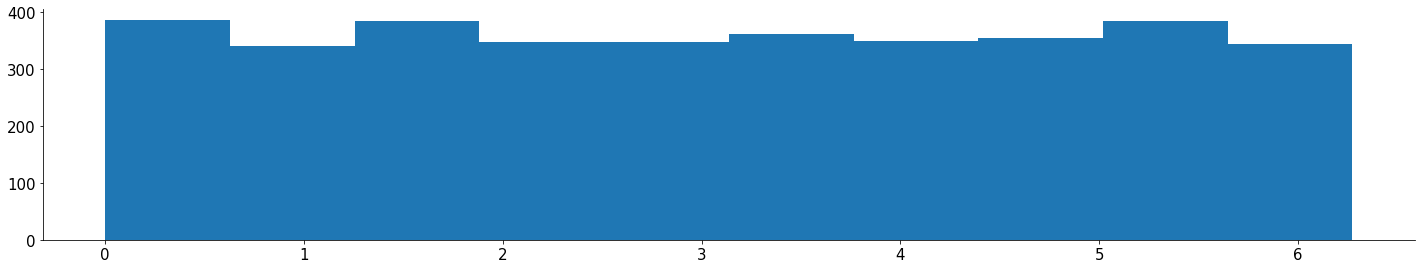

In [12]:
plt.hist(dat_a)

In [13]:
dat_r.shape

(23589, 3598)

## PCA and linear regression, speed

In [65]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dat_r.T, run_ordered_r0, train_size=train_size, random_state=rng)
Z_train = scipy.stats.zscore(X_train, axis=0)
Z_test = scipy.stats.zscore(X_test, axis=0)

In [66]:
K = 200
pipe = sklearn.pipeline.Pipeline([
                                  ('pca', sklearn.decomposition.PCA(n_components=K, whiten=True, random_state=rng)),
                                  ('linear_regression', sklearn.linear_model.LinearRegression(fit_intercept=True))
                                 ])

Using more than 200 dimensions starts to overfit the data

In [67]:
pipe.fit(Z_train, y_train)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=200,
                     random_state=RandomState(MT19937) at 0x7F2B408DEBA0,
                     svd_solver='auto', tol=0.0, whiten=True)),
                ('linear_regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [68]:
y_train_pred = pipe.predict(Z_train)

In [69]:
y_test_pred = pipe.predict(Z_test)

In [70]:
mse = sklearn.metrics.mean_squared_error(y_test, y_test_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average test error of {mean_error} """

'Our model has an average test error of 8.157346338697439 '

In [71]:
mse = sklearn.metrics.mean_squared_error(y_train, y_train_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average train error of {mean_error} """

'Our model has an average train error of 7.579010541554312 '

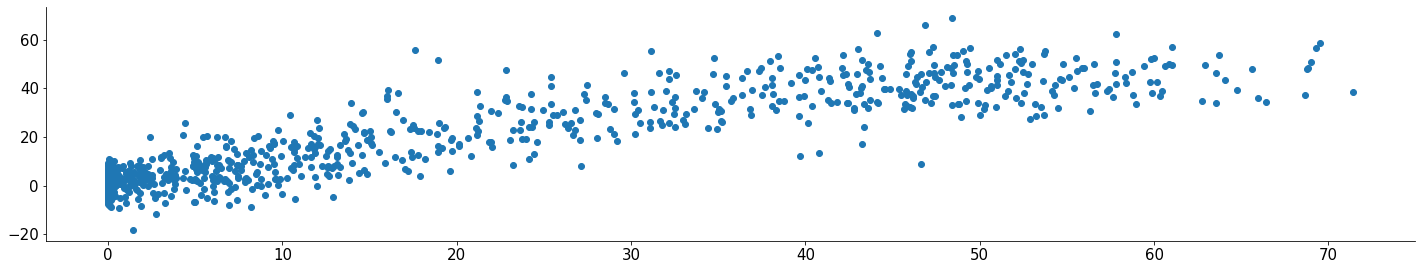

In [42]:
plt.scatter(y_test, y_test_pred)

In [72]:
sklearn.metrics.r2_score(y_test,y_test_pred)

0.8293956235271529

In [73]:
sklearn.metrics.r2_score(y_train,y_train_pred)

0.8545228474448131

## Looking at PC space of train and test data labeled by speed

In [74]:
train_transform = pipe.named_steps['pca'].transform(Z_train)

In [75]:
test_transform = pipe.named_steps['pca'].transform(Z_test)

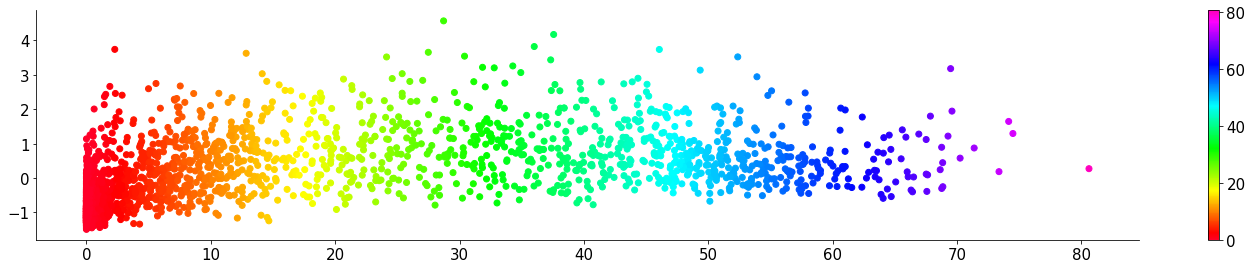

In [77]:
plt.scatter(y_train,train_transform[:,0],c = y_train,cmap='gist_rainbow')
plt.colorbar()

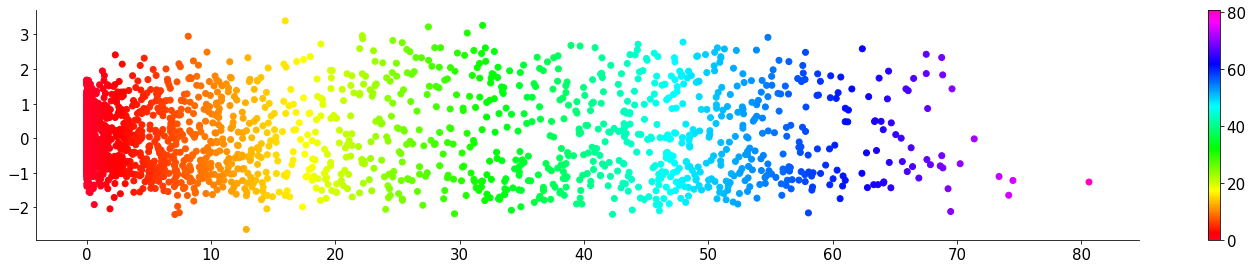

In [78]:
plt.scatter(y_train,train_transform[:,1],c = y_train,cmap='gist_rainbow')
plt.colorbar()

In [342]:
idx_speed_train = np.argsort(y_train)

Note that the colorbar is not even

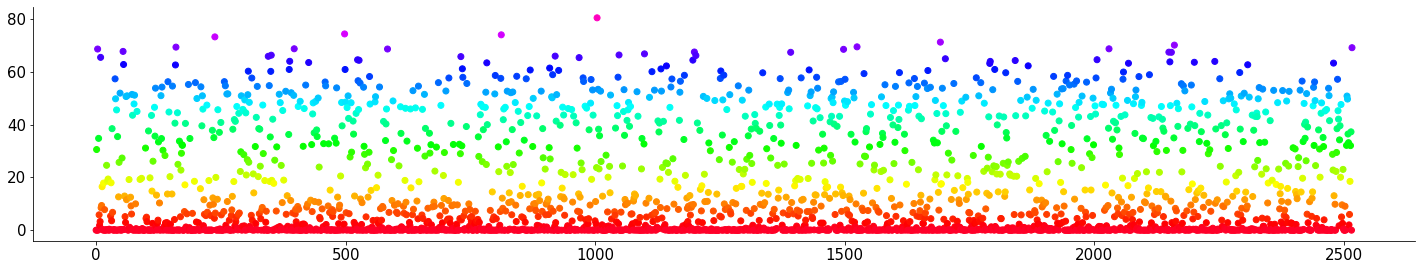

In [79]:
plt.scatter(np.arange(len(y_train)),y_train,c = y_train,cmap='gist_rainbow')

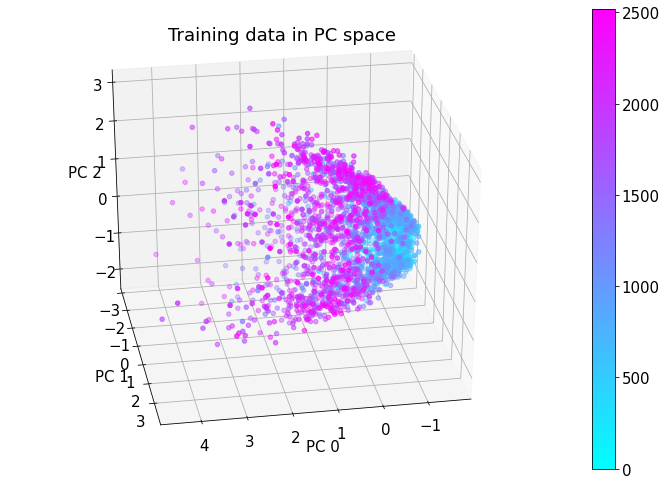

In [344]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(train_transform[idx_speed_train,0],train_transform[idx_speed_train,1],train_transform[idx_speed_train,2],c = np.arange(len(y_train)),cmap='cool')
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
plt.title('Training data in PC space')
fig.colorbar(p)
ax.view_init(30,80)

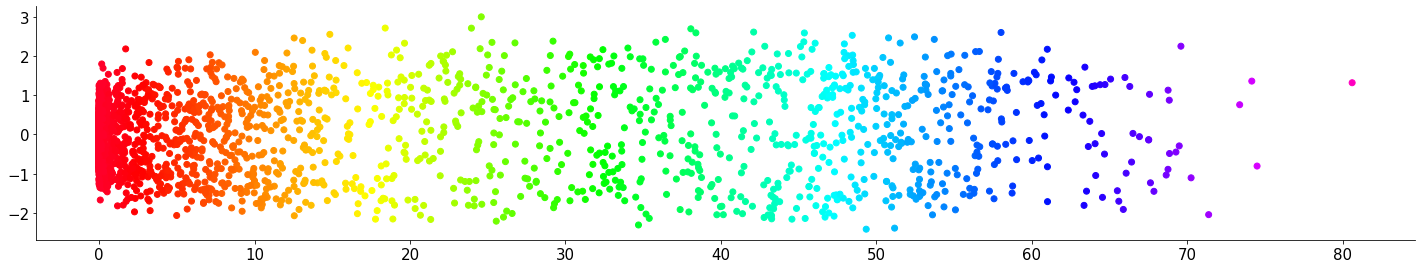

In [84]:
plt.scatter(y_train,train_transform[:,2],c = y_train,cmap='gist_rainbow')

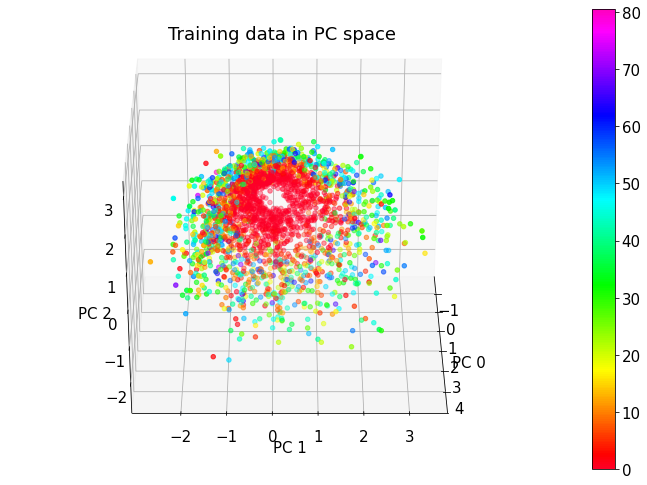

In [86]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(train_transform[:,0],train_transform[:,1],train_transform[:,2],c = y_train,cmap='gist_rainbow')
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
plt.title('Training data in PC space')
fig.colorbar(p)
ax.view_init(30,360)

In [257]:
idx_speed_test = np.argsort(y_test)

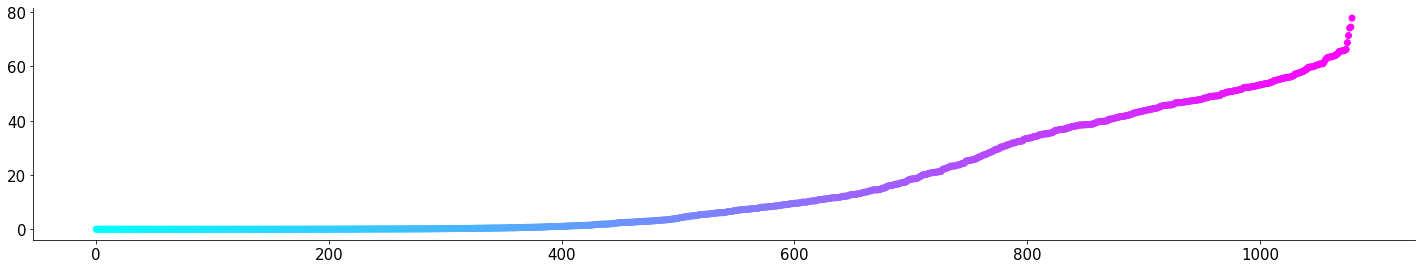

In [258]:
plt.scatter(np.arange(len(y_test)),y_test[idx_speed_test],c = np.arange(len(y_test)),cmap='cool')

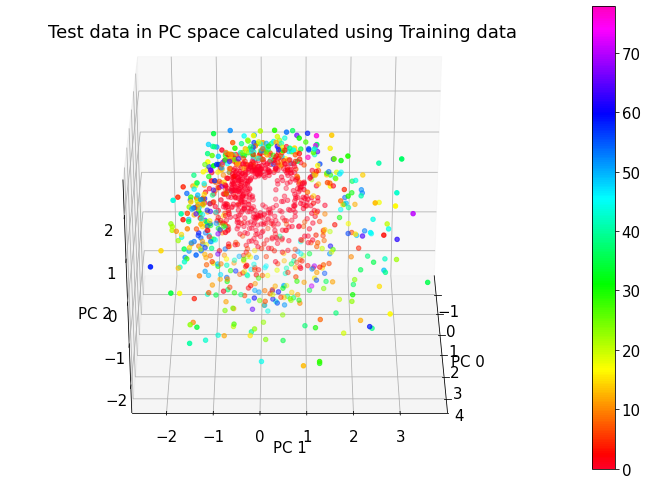

In [85]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(test_transform[:,0],test_transform[:,1],test_transform[:,2],c = y_test,cmap='gist_rainbow')
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
plt.title('Test data in PC space calculated using Training data')
fig.colorbar(p)
ax.view_init(30,360)

## Redoing angles using removed speeds

In [263]:
dat_r.shape

(23589, 3598)

In [51]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dat_r.T, dat_a, train_size=train_size, random_state=rng)
Z_train = scipy.stats.zscore(X_train, axis=0)
Z_test = scipy.stats.zscore(X_test, axis=0)

In [52]:
K = 200
pipe = sklearn.pipeline.Pipeline([
                                  ('pca', sklearn.decomposition.PCA(n_components=K, whiten=True, random_state=rng)),
                                  ('linear_regression', sklearn.linear_model.LinearRegression(fit_intercept=True))
                                 ])

Using more than 200 dimensions starts to overfit the data

In [53]:
pipe.fit(Z_train, y_train)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=200,
                     random_state=RandomState(MT19937) at 0x7F2B408DEBA0,
                     svd_solver='auto', tol=0.0, whiten=True)),
                ('linear_regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [54]:
y_train_pred = pipe.predict(Z_train)

In [55]:
y_test_pred = pipe.predict(Z_test)

In [56]:
mse = sklearn.metrics.mean_squared_error(y_test, y_test_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average test error of {round(360 * mean_error / (np.pi * 2))} degrees"""

'Our model has an average test error of 44.0 degrees'

In [57]:
mse = sklearn.metrics.mean_squared_error(y_train, y_train_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average train error of {round(360 * mean_error / (np.pi * 2))} degrees"""

'Our model has an average train error of 43.0 degrees'

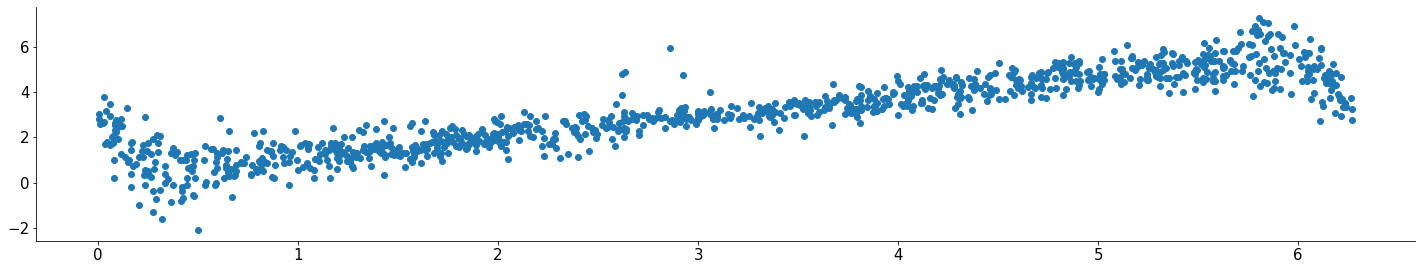

In [21]:
plt.scatter(y_test, y_test_pred)

In [22]:
sklearn.metrics.r2_score(y_test,y_test_pred)

0.8104308102318001

In [23]:
sklearn.metrics.r2_score(y_train,y_train_pred)

0.8274077285469938

## Looking at PC space of train and test data labeled by angle orientation

In [274]:
np.mean(Z_test,0)

array([-8.51941974e-17, -3.97315925e-17,  7.24728919e-18, ...,
       -1.37338700e-16, -4.61307947e-18,  1.01770444e-17])

In [60]:
train_transform = pipe.named_steps['pca'].transform(Z_train)

In [61]:
test_transform = pipe.named_steps['pca'].transform(Z_test)

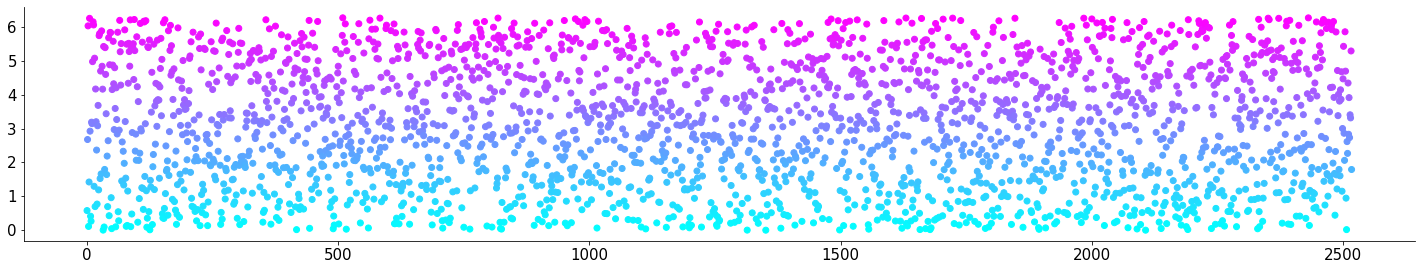

In [31]:
plt.scatter(np.arange(len(y_train)),y_train,c = y_train,cmap='cool')

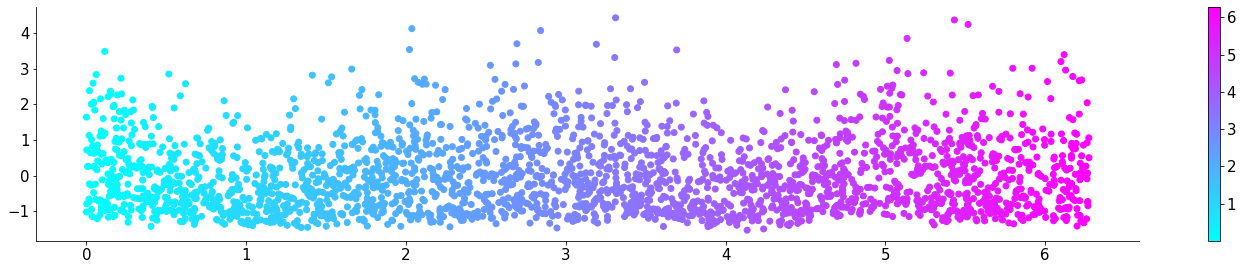

In [29]:
plt.scatter(y_train,train_transform[:,0],c = y_train,cmap='cool')
plt.colorbar()

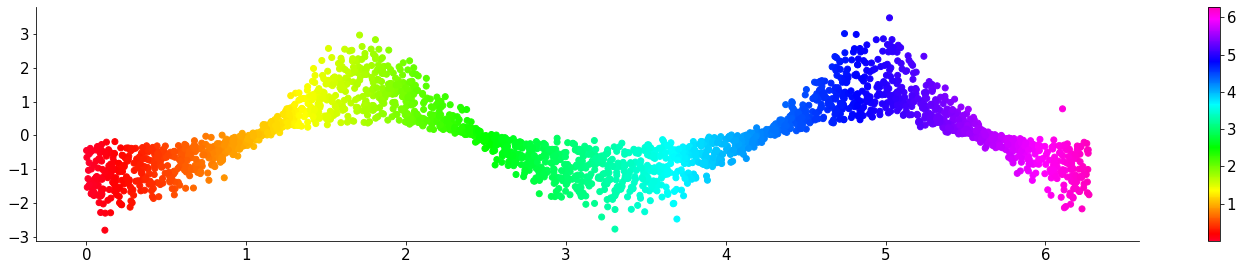

In [62]:
plt.scatter(y_train,train_transform[:,1],c = y_train,cmap='gist_rainbow')
plt.colorbar()

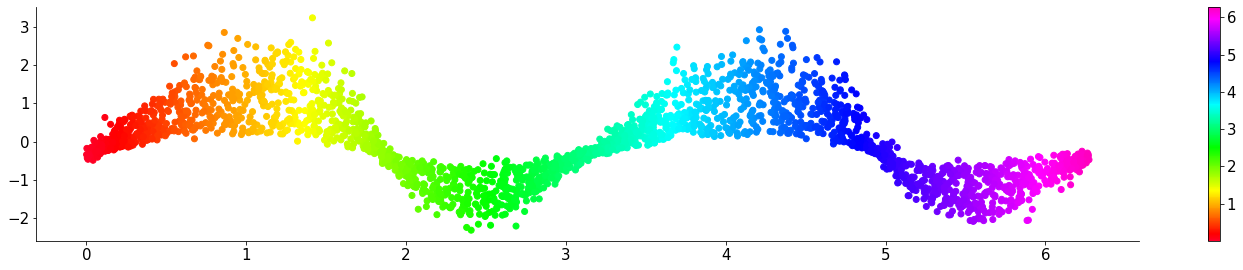

In [63]:
plt.scatter(y_train,train_transform[:,2],c = y_train,cmap='gist_rainbow')
plt.colorbar()

In [363]:
idx_ang_train = np.argsort(y_train)

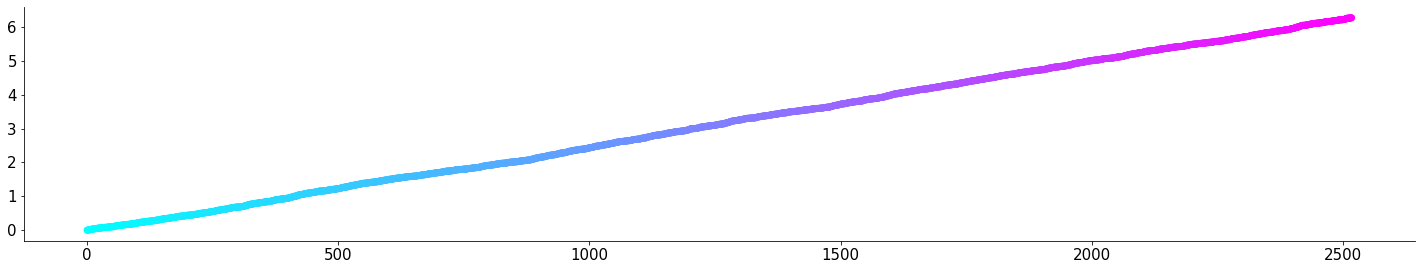

In [364]:
plt.scatter(np.arange(len(y_train)),y_train[idx_ang_train],c = np.arange(len(y_train)),cmap='cool')

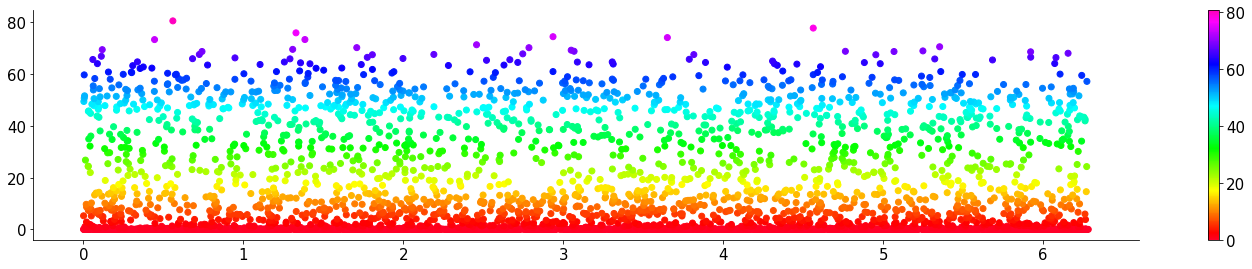

In [90]:
idx_r = np.argsort(dat['run'])
plt.scatter(dat['istim'][idx_r],dat['run'][idx_r],c =dat['run'][idx_r] ,cmap='gist_rainbow')
plt.colorbar()

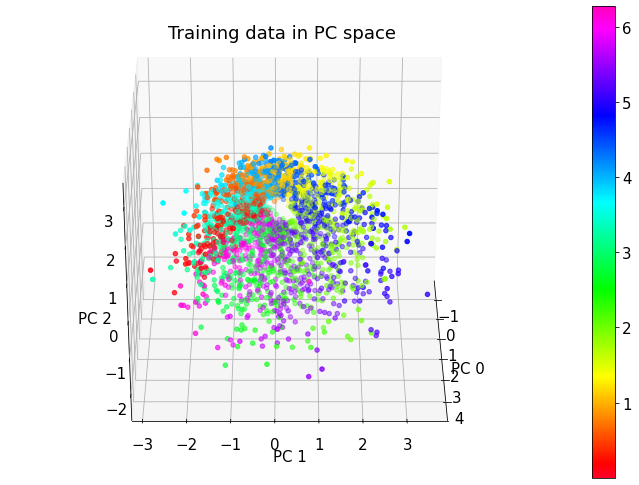

In [64]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(train_transform[:,0],train_transform[:,1],train_transform[:,2],c = y_train,cmap='gist_rainbow')
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
plt.title('Training data in PC space')
fig.colorbar(p)
ax.view_init(30,360)

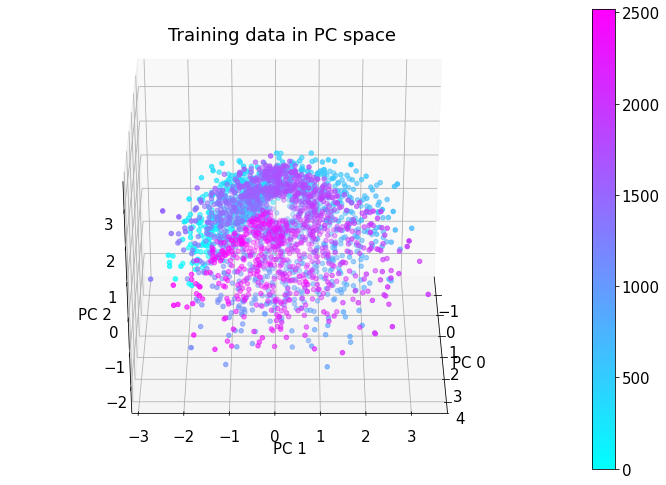

In [365]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(train_transform[idx_ang_train,0],train_transform[idx_ang_train,1],train_transform[idx_ang_train,2],c = np.arange(len(y_train)),cmap='cool')
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
plt.title('Training data in PC space')
fig.colorbar(p)
ax.view_init(30,360)

In [367]:
idx_ang_test = np.argsort(y_test)

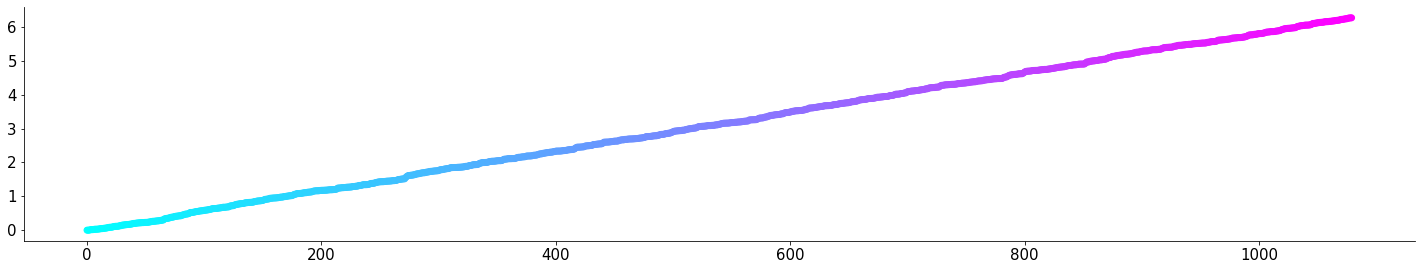

In [368]:
plt.scatter(np.arange(len(y_test)),y_test[idx_ang_test],c = np.arange(len(y_test)),cmap='cool')

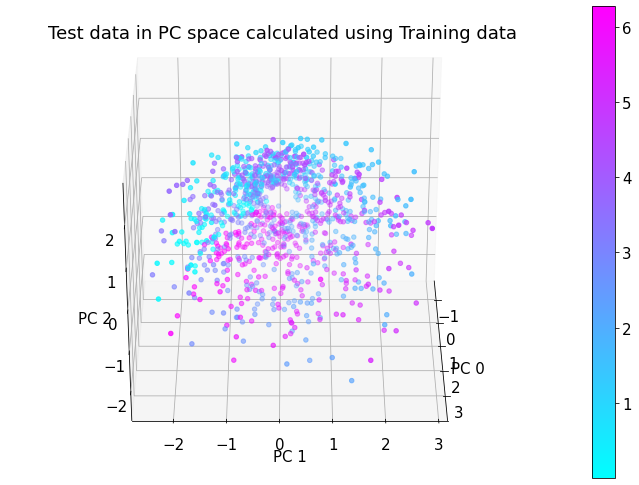

In [34]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(test_transform[:,0],test_transform[:,1],test_transform[:,2],c = y_test,cmap='cool')
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
plt.title('Test data in PC space calculated using Training data')
fig.colorbar(p)
ax.view_init(30,360)

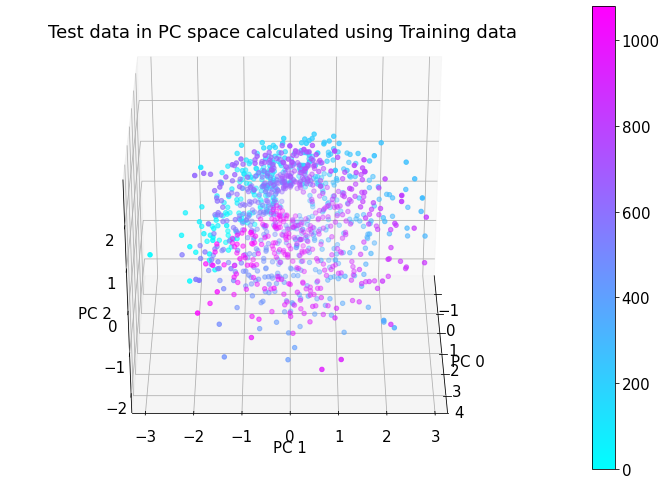

In [369]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
p = ax.scatter(test_transform[idx_ang_test,0],test_transform[idx_ang_test,1],test_transform[idx_ang_test,2],c = np.arange(len(y_test)),cmap='cool')
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
plt.title('Test data in PC space calculated using Training data')
fig.colorbar(p)
ax.view_init(30,360)

# Redoing plain linear regression with removed speeds

## Angles

In [283]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dat_r.T, dat_a, train_size=train_size, random_state=rng)
Z_train = scipy.stats.zscore(X_train, axis=0)
Z_test = scipy.stats.zscore(X_test, axis=0)

In [284]:
reg = sklearn.linear_model.LinearRegression().fit(Z_train,y_train)

In [285]:
y_train_pred = reg.predict(Z_train)

In [286]:
y_test_pred = reg.predict(Z_test)

In [287]:
mse = sklearn.metrics.mean_squared_error(y_test, y_test_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average test error of {round(360 * mean_error / (np.pi * 2))} degrees"""

'Our model has an average test error of 38.0 degrees'

In [288]:
sklearn.metrics.r2_score(y_test,y_test_pred)

0.8701501012593125

In [289]:
mse = sklearn.metrics.mean_squared_error(y_train, y_train_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average train error of {round(360 * mean_error / (np.pi * 2))} degrees"""

'Our model has an average train error of 0.0 degrees'

In [290]:
sklearn.metrics.r2_score(y_train,y_train_pred)

1.0

## Speed

In [291]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dat_r.T, run_ordered_r0, train_size=train_size, random_state=rng)
Z_train = scipy.stats.zscore(X_train, axis=0)
Z_test = scipy.stats.zscore(X_test, axis=0)

In [292]:
reg = sklearn.linear_model.LinearRegression().fit(Z_train,y_train)

In [293]:
y_train_pred = reg.predict(Z_train)

In [294]:
y_test_pred = reg.predict(Z_test)

In [296]:
mse = sklearn.metrics.mean_squared_error(y_test, y_test_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average test error of {mean_error} """

'Our model has an average test error of 7.096716439727005 '

In [297]:
sklearn.metrics.r2_score(y_test,y_test_pred)

0.866655552194668

In [298]:
mse = sklearn.metrics.mean_squared_error(y_train, y_train_pred)
mean_error = np.sqrt(mse)
f"""Our model has an average train error of {mean_error} """

'Our model has an average train error of 6.25217207264702e-14 '

In [299]:
sklearn.metrics.r2_score(y_train,y_train_pred)

1.0